In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta, date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 7))
mpl.__version__
style.use('ggplot')

import torch 
import torch.nn as nn
from torch.autograd import Variable
import math
from sklearn.metrics import mean_squared_error

In [33]:
df = pd.read_csv("BANKNIFTY_F1_2020.csv")
df.shape

(54877, 10)

# Intial Analysis

In [5]:
df.head(5)

,close,datetime,exchange,expiryDate,high,internalName,low,open,unknown,volume
0,32456.05,2020-01-01 09:16,NSE,2020-1-30 23:59,32465.15,BANKNIFTY JAN FUT,32353.90,32417.30,1304980,36240
1,32444.55,2020-01-01 09:17,NSE,2020-1-30 23:59,32466.00,BANKNIFTY JAN FUT,32444.55,32457.00,1304980,18780
2,32445.00,2020-01-01 09:18,NSE,2020-1-30 23:59,32452.00,BANKNIFTY JAN FUT,32445.00,32446.40,1316960,14900
3,32463.65,2020-01-01 09:19,NSE,2020-1-30 23:59,32463.65,BANKNIFTY JAN FUT,32435.00,32445.00,1316960,18120
4,32465.00,2020-01-01 09:20,NSE,2020-1-30 23:59,32474.00,BANKNIFTY JAN FUT,32456.90,32460.75,1316960,11540


In [6]:
df.tail(5)

,close,datetime,exchange,expiryDate,high,internalName,low,open,unknown,volume
54872,21689.0,2020-07-31 15:28,NSE,2020-8-27 23:59,21691.7,BANKNIFTY AUG FUT,21683.00,21688.45,1415200,11600
54873,21700.0,2020-07-31 15:29,NSE,2020-8-27 23:59,21700.0,BANKNIFTY AUG FUT,21688.55,21689.00,1415200,14575
54874,21700.0,2020-07-31 15:30,NSE,2020-8-27 23:59,21710.0,BANKNIFTY AUG FUT,21692.00,21700.00,1415200,16400
54875,21695.0,2020-07-31 15:31,NSE,2020-8-27 23:59,21695.0,BANKNIFTY AUG FUT,21695.00,21695.00,1415200,275
54876,21691.5,2020-07-31 18:39,NSE,2020-8-27 23:59,21691.5,BANKNIFTY AUG FUT,21691.50,21691.50,1359675,1


In [7]:
df.describe()

,close,high,low,open,unknown,volume
count,54877.000000,54877.000000,54877.000000,54877.000000,5.487700e+04,54877.000000
mean,23990.783494,24007.028562,23974.910808,23990.911139,1.470169e+06,16086.975436
std,5120.578964,5115.829353,5125.107616,5120.635419,3.016633e+05,15804.091433
min,16076.000000,16163.800000,16020.550000,16074.650000,2.266400e+05,1.000000
25%,19845.000000,19867.900000,19823.600000,19844.600000,1.294160e+06,6400.000000
50%,21840.100000,21852.250000,21826.700000,21840.150000,1.474060e+06,11600.000000
75%,30530.000000,30540.000000,30520.800000,30530.000000,1.668400e+06,20060.000000
max,32602.050000,32606.050000,32594.000000,32600.000000,2.216340e+06,274160.000000


In [8]:
 df.isnull().sum()

close           0
datetime        0
exchange        0
expiryDate      0
high            0
internalName    0
low             0
open            0
unknown         0
volume          0
dtype: int64

In [9]:
df.exchange.unique()

array(['NSE'], dtype=object)

In [10]:
df.internalName.unique()

array(['BANKNIFTY JAN FUT', 'BANKNIFTY FEB FUT', 'BANKNIFTY MAR FUT',
       'BANKNIFTY APR FUT', 'BANKNIFTY MAY FUT', 'BANKNIFTY JUN FUT',
       'BANKNIFTY JUL FUT', 'BANKNIFTY AUG FUT'], dtype=object)

In [11]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020,1,1)
end_dt = date(2020,7,31)
weekdays = [5,6]

# gives all dates exculding weekdays
dates = [dt.strftime("%Y-%m-%d") for dt in daterange(start_dt, end_dt) if dt.weekday() not in weekdays]



In [12]:
all_days_in_csv = set([_.split(" ")[0] for _ in df.datetime])
all_days_between_date = dates

print ("MISSING DATES EXCLUDING WEEKENDS")
for _ in dates:
    if _ not in all_days_in_csv:
        print (_)

MISSING DATES EXCLUDING WEEKENDS
2020-02-21
2020-03-10
2020-04-02
2020-04-06
2020-04-10
2020-04-14
2020-05-01
2020-05-25


# What does these dates mean....?

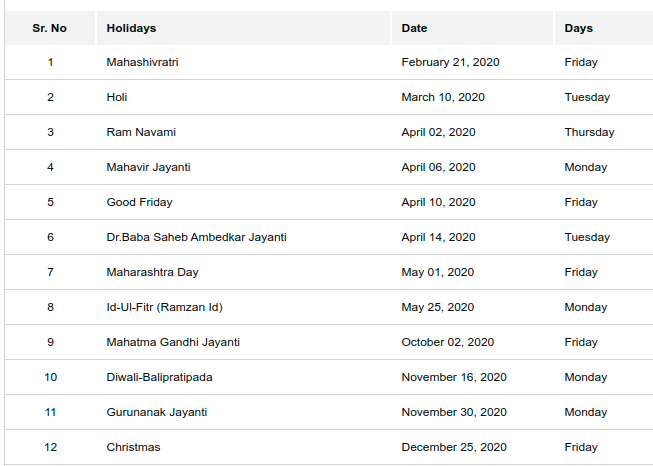

In [13]:
from IPython.display import Image
Image(filename='01.png')

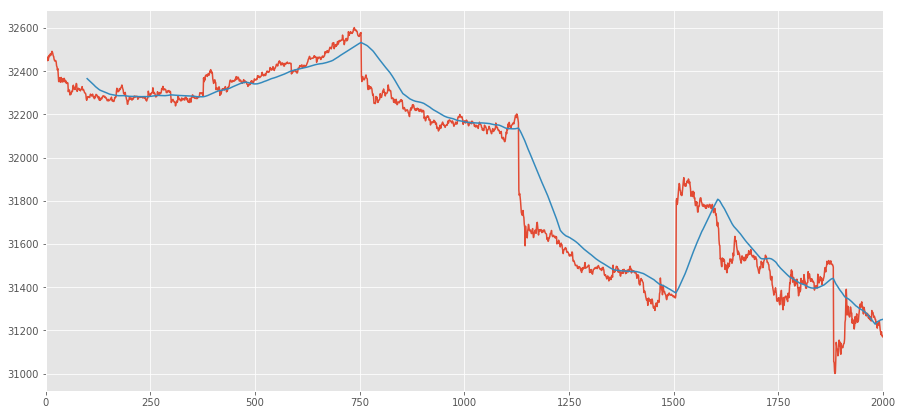

In [14]:
# Rolling Mean
mavg = df.close[:2000].rolling(window=100).mean()
df.close[:2000].plot()
mavg.plot()

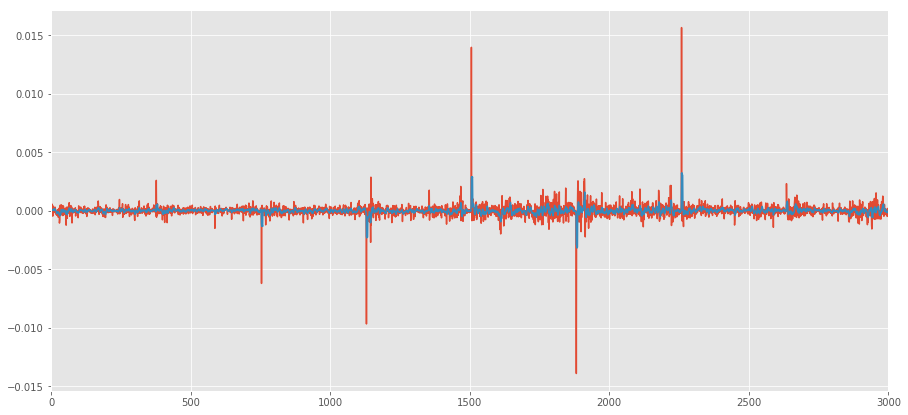

In [15]:
returns = df.close[:3000] / df.close[:3000].shift(1) - 1
mavg_r = returns.rolling(window=5).mean()
returns.plot()
mavg_r.plot()

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df.close = scaler.fit_transform(df.close.values.reshape(-1,1))

In [17]:
def load_data(stock, look_back, test_ratio=0.2):
    # convert to numpy array
    data_raw = stock.as_matrix() 
    data = []
    
    # convert [1,2,3,4,5] = [[1,2],[2,3],[3,4],[455]]
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(test_ratio*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1]
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    y_train = data[:train_set_size,-1]
    y_train = np.reshape(y_train, (x_train.shape[0],1))
    
    x_test = data[train_set_size:,:-1]
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    y_test = data[train_set_size:,-1]
    y_test = np.reshape(y_test,(y_test.shape[0],1))
    
    return [x_train, y_train, x_test, y_test]

In [18]:
look_back = 20 
x_train, y_train, x_test, y_test = load_data(df.close, look_back)

print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_test.shape = {}'.format(x_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_train.shape = (43886, 19, 1)
y_train.shape = (43886, 1)
x_test.shape = (10971, 19, 1)
y_test.shape = (10971, 1)


/home/dckap/hobby/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# convert to Tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
x_train.size()

torch.Size([43886, 19, 1])

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # print (x.shape,x.size(0))
        
        # Initialize hidden state, cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [22]:
model = LSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


/home/dckap/hobby/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [23]:
print(model)


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [24]:

num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  10 MSE:  0.023230545222759247
Epoch  20 MSE:  0.012025977484881878
Epoch  30 MSE:  0.005461462773382664
Epoch  40 MSE:  0.004205580335110426
Epoch  50 MSE:  0.0019203112460672855
Epoch  60 MSE:  0.0012179662007838488
Epoch  70 MSE:  0.0005796935292892158
Epoch  80 MSE:  0.0002725076919887215
Epoch  90 MSE:  0.00011753928993130103


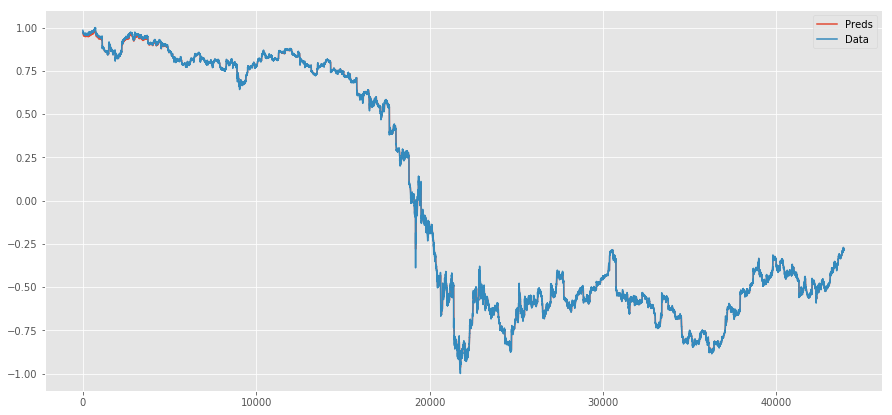

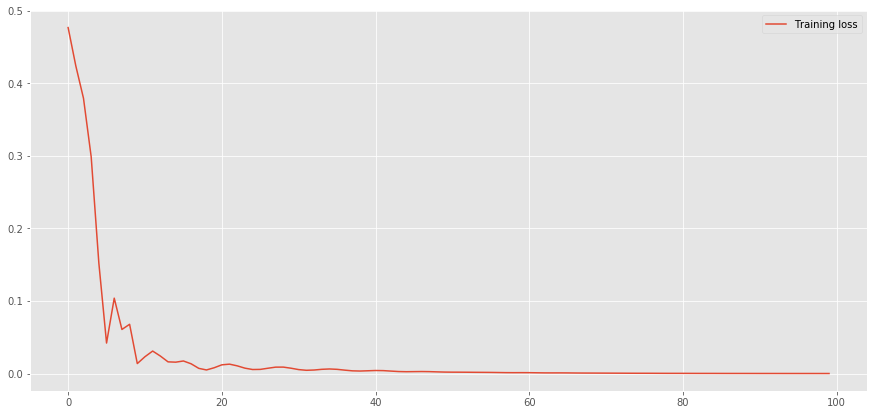

In [25]:

plt.show()
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()

In [26]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 71.62 RMSE
Test Score: 37.99 RMSE


(54877, 1)


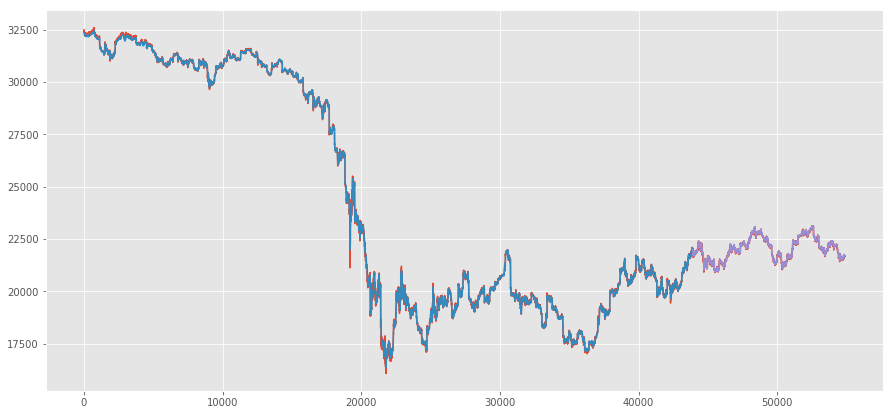

In [27]:
trainPredictPlot = np.empty_like(df.close)

trainPredictPlot[:] = np.nan
trainPredictPlot = np.reshape(trainPredictPlot,(trainPredictPlot.shape[0],1))
print(trainPredictPlot.shape)

trainPredictPlot[look_back:len(y_train_pred)+look_back] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df.close)

testPredictPlot[:] = np.nan
testPredictPlot = np.reshape(testPredictPlot,(testPredictPlot.shape[0],1))

testPredictPlot[len(y_train_pred)+look_back-1:len(df.close)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure()
plt.plot(scaler.inverse_transform(df.close.values.reshape(-1, 1)))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()